# 03 Running a simulation

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import jellybamm
import liionpack as lp
import pybamm
import numpy as np


In [2]:
pybamm.__version__

'24.9.0'

{'alpha_radial': 1.243781922367203e-06, 'alpha_spiral': 1.5746847123266335e-05, 'lump_rho': 2705.51593625498, 'lump_Cp': 653.3224510351804}


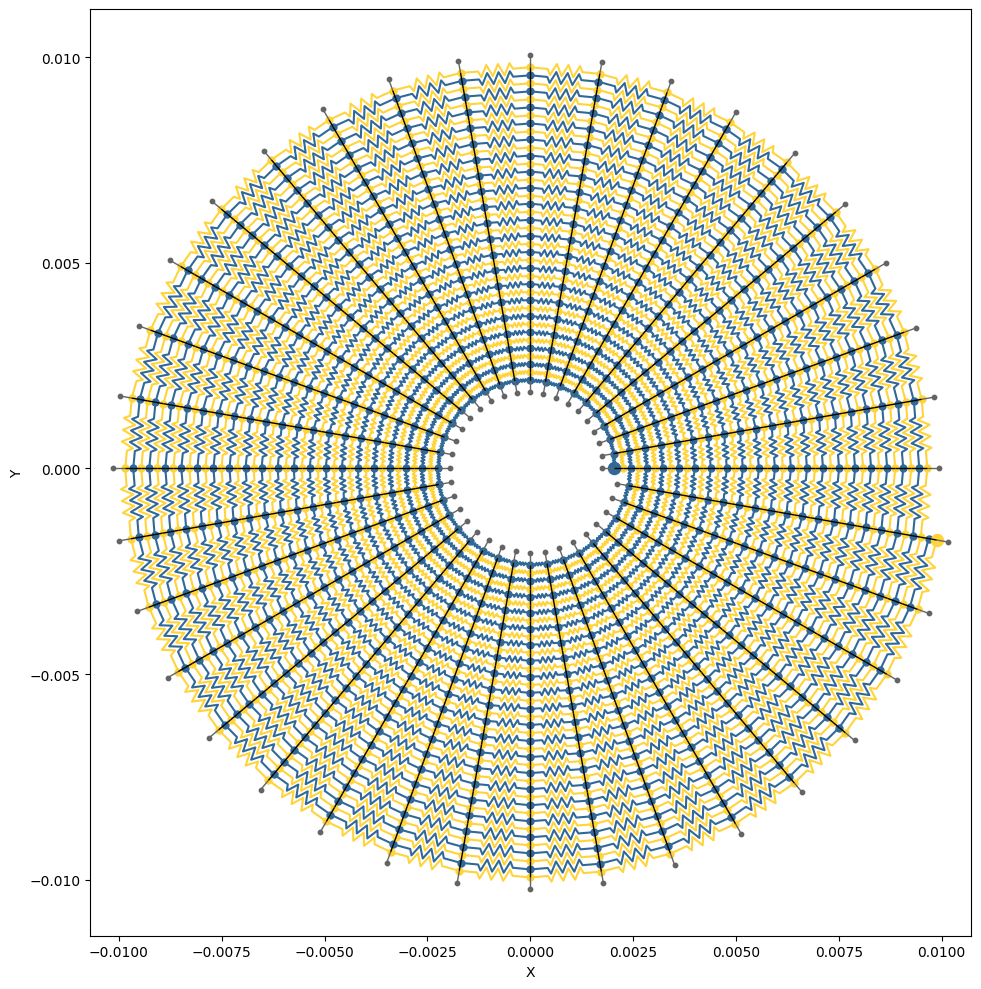

In [3]:
# pybamm.set_logging_level("INFO")
lp.logger.setLevel("NOTICE")
wrk = op.Workspace()
wrk.clear()
wrk.settings["loglevel"] = 100

# Geometry of spiral
Nlayers = 20
dtheta = 10
spacing = 195e-6  # To do should come from params
inner_r = 10 * spacing
pos_tabs = [-1]
neg_tabs = [0]
length_3d = 0.08
tesla_tabs = False

# Experiment
I_app = 6
dt = 5
Nsteps = 360
hours = dt * Nsteps / 3600
experiment = pybamm.Experiment(
    [
        (f"Discharge at {I_app} A for {hours} hours or until 2.5 V"),
        (f"Rest for 5 minutes"),
        (f"Charge at {I_app} A for {hours} hours or until 4.5 V"),
    ],
    period=f"{dt} seconds",
)

# OpenPNM project
project, arc_edges = jellybamm.make_spiral_net(
    Nlayers, dtheta, spacing, inner_r, pos_tabs, neg_tabs, length_3d, tesla_tabs
)
jellybamm.plot_topology(project.network)
# Parameter set
param = pybamm.ParameterValues("Chen2020")
# param.update({"Initial concentration in negative electrode [mol.m-3]": param["Maximum concentration in negative electrode [mol.m-3]"]*0.5,
#               "Initial concentration in positive electrode [mol.m-3]": param["Maximum concentration in positive electrode [mol.m-3]"]*0.7})
# JellyBaMM discretises the spiral using the electrode height for spiral length
# This parameter set has the longer length set to the Electrode width
# We want to swap this round
param["Electrode width [m]"] = length_3d
# Passing None as initial_soc will take values from Parameter set and apply
# uniformly everywhere
initial_soc = 0.5
thermal_props = print(jellybamm.lump_thermal_props(param))


In [4]:
# Run simulation
project, output = jellybamm.run_simulation_lp(
    parameter_values=param, experiment=experiment, initial_soc=None, project=project
)

------------------------------------------------------------
NOTICE     : Parameter: Current function [A] has been set to input 
SOURCE     : liionpack.logger.check_current_function 
TIME STAMP : 2024-09-16 23:04:11,754
------------------------------------------------------------
------------------------------------------------------------
NOTICE     : Starting step solve for step 0 
SOURCE     : liionpack.logger.run_simulation_lp 
TIME STAMP : 2024-09-16 23:04:13,354
------------------------------------------------------------
Stepping simulation (1/3):   0%|          | 0/361 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Stepping simulation (1/3): 100%|██████████| 361/361 [07:12<00:00,  1.20s/it]
------------------------------------------------------------
NOTICE     : Step solve finished 
SOURCE     : liionpack.logger.run_simulation_lp 
TIME STAMP : 2024-09-16 23:11:26,295
------------------------------------------------------------
------------------------------------------------------------
NOTICE     : Total stepping time 432.94s 
SOURCE     : liionpack.logger.run_simulation_lp 
TIME STAMP : 2024-09-16 23:11:26,300
------------------------------------------------------------
------------------------------------------------------------
NOTICE     : Time per step 0.554s 
SOURCE     : liionpack.logger.run_simulation_lp 
TIME STAMP : 2024-09-16 23:11:26,305
------------------------------------------------------------
------------------------------------------------------------
NOTICE     : Starting step solve for step 1 
SOURCE     : liionpack.logger.run_simulation_lp 
TIME STAMP : 2024-09-16 23:11:26,

******************************
Step Sim time 654.994882106781
******************************


In [5]:
net = project.network
net.num_pores("free_stream")

36

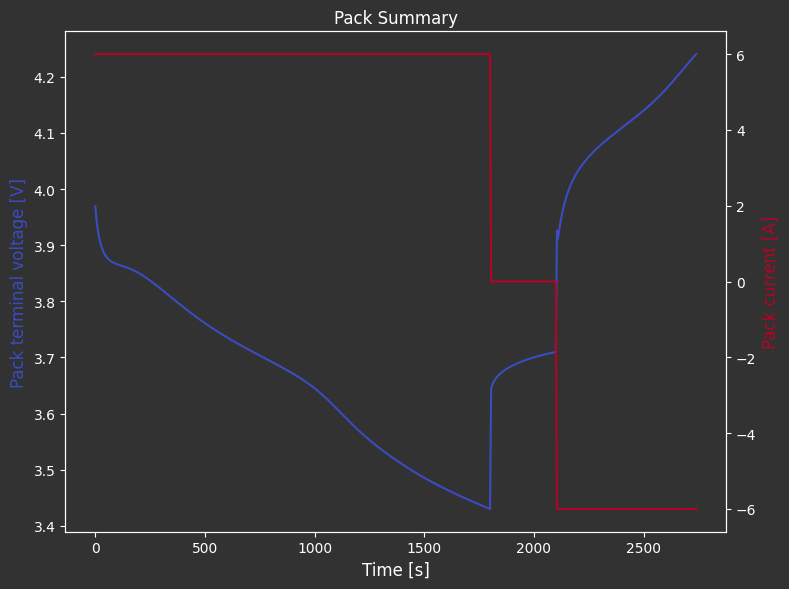

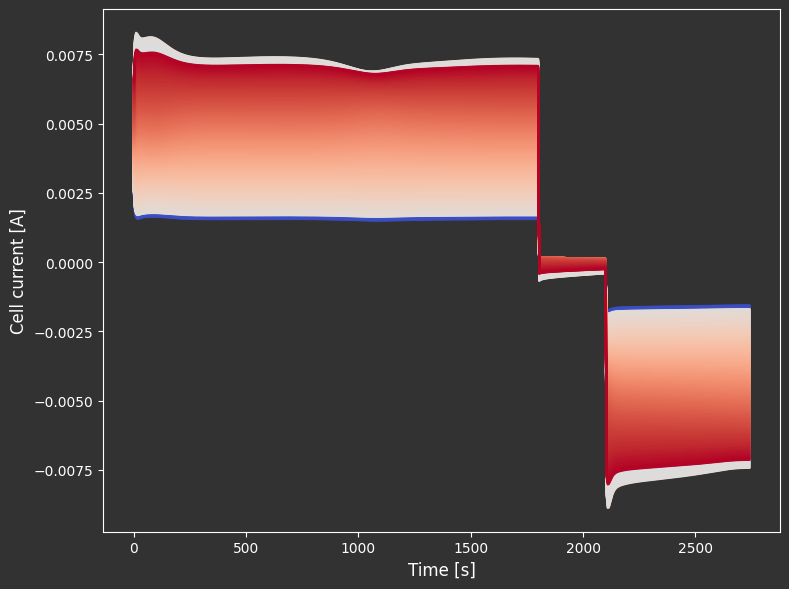

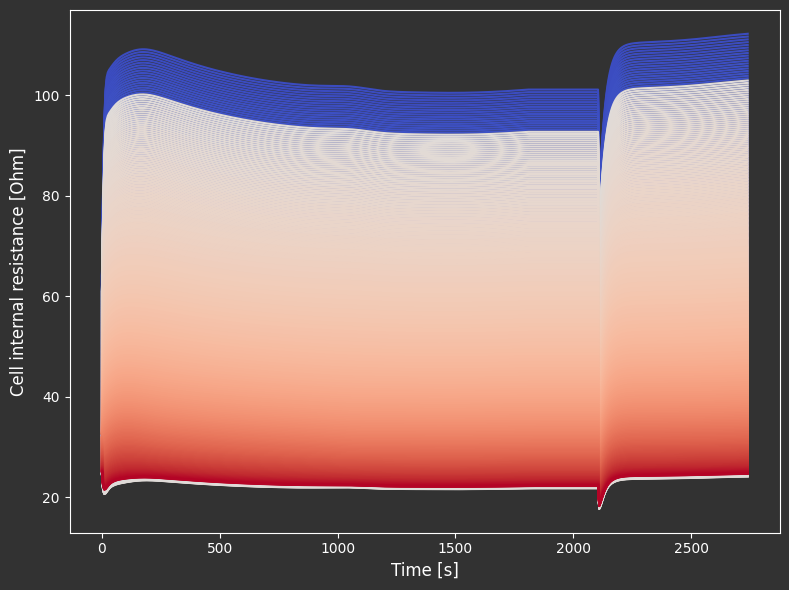

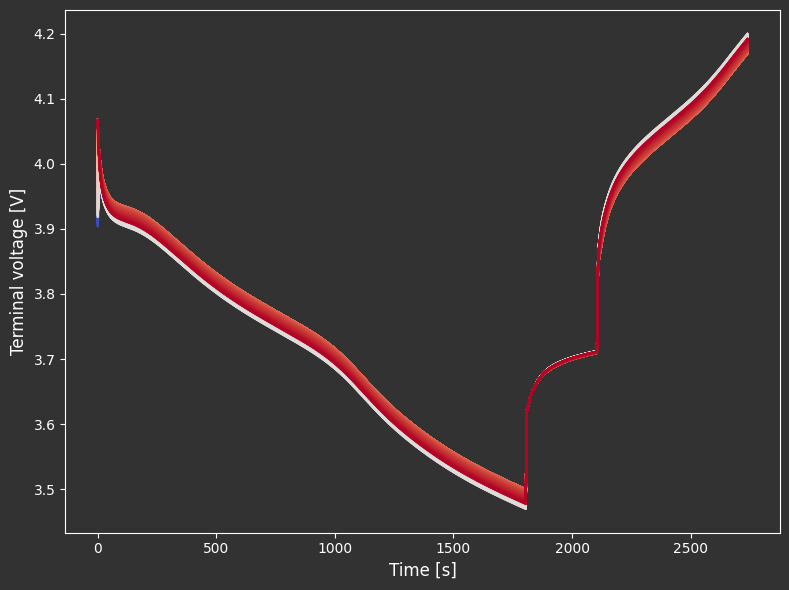

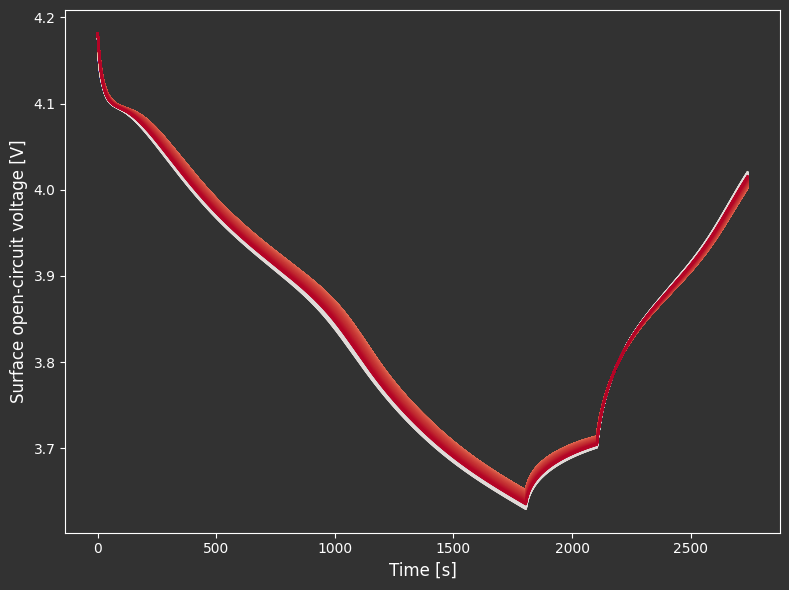

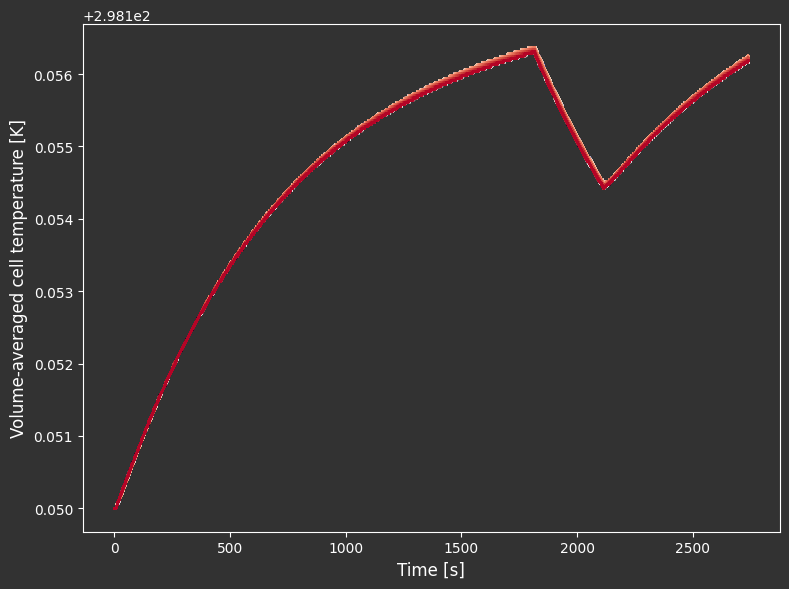

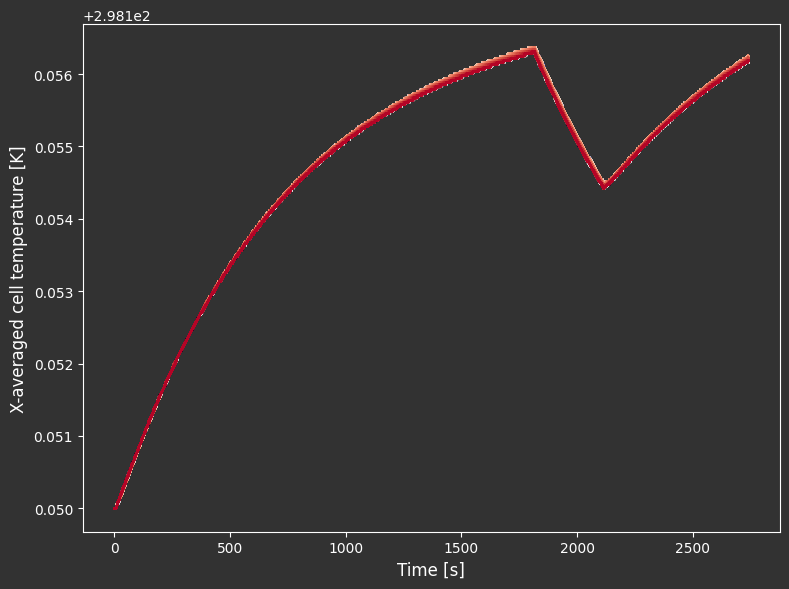

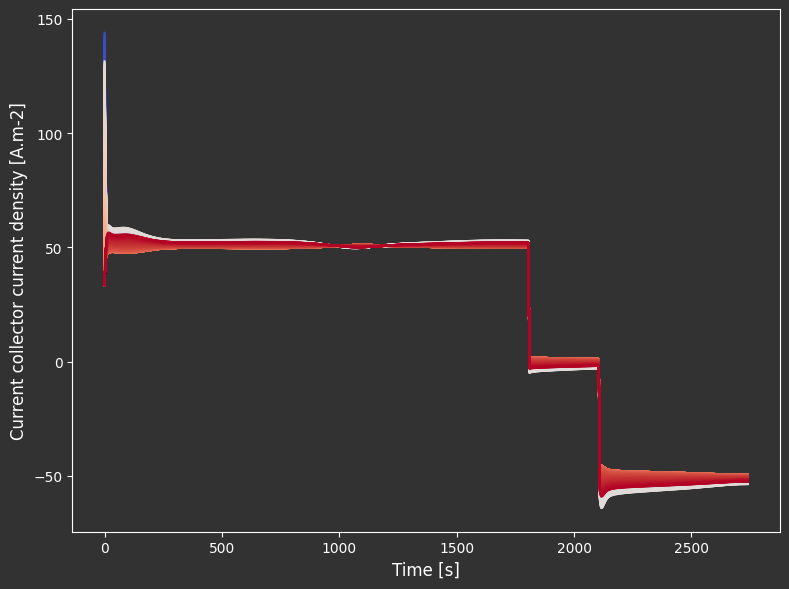

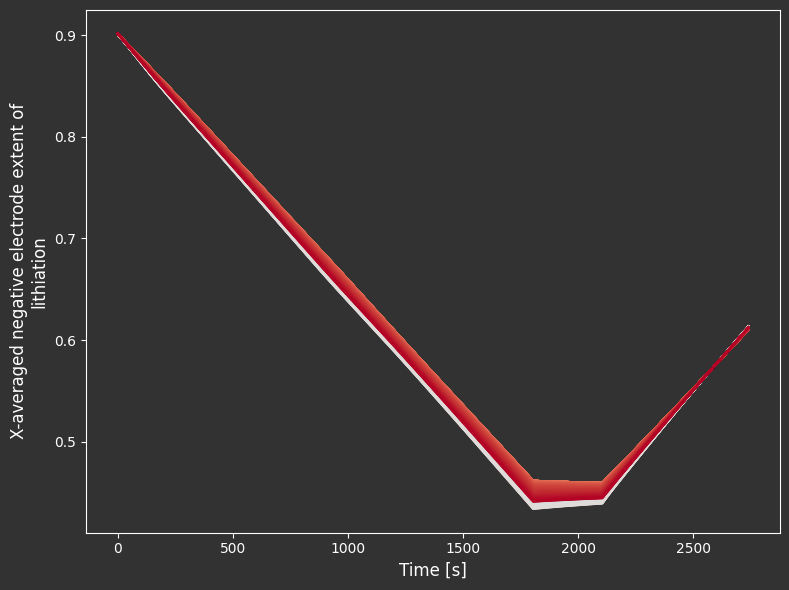

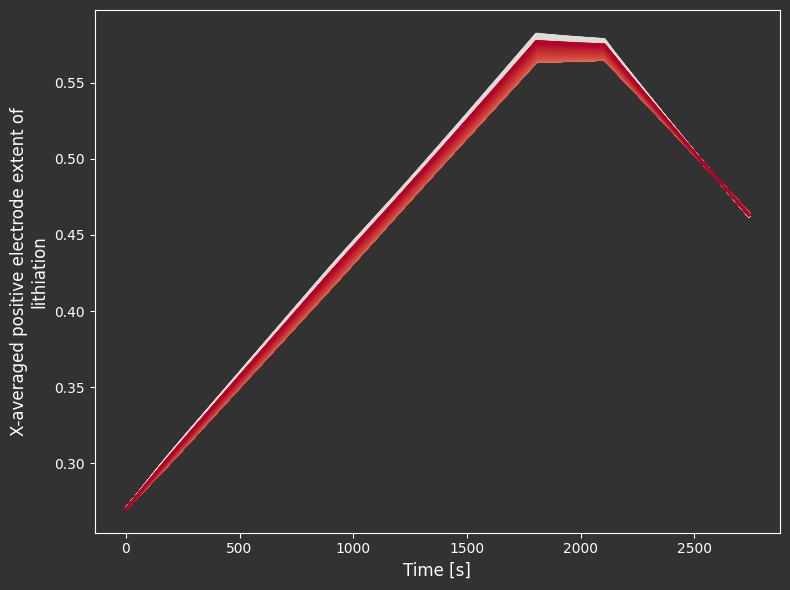

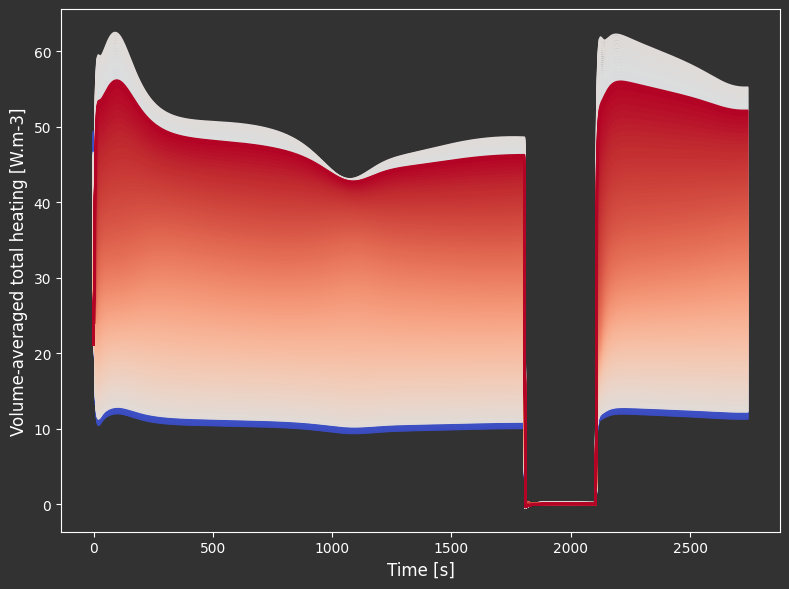

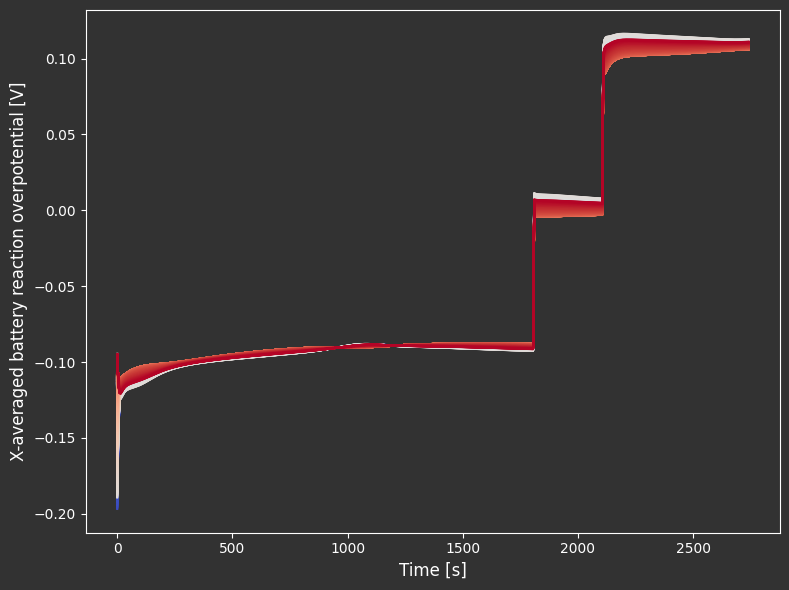

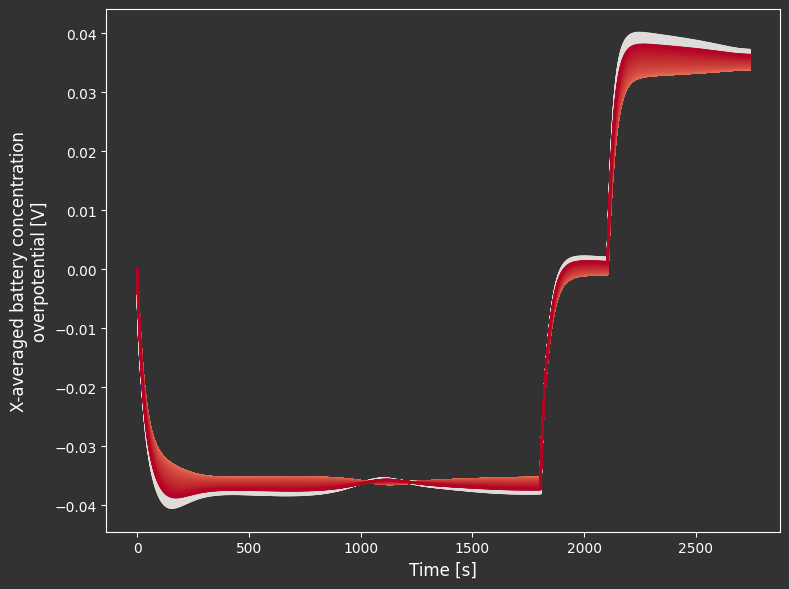

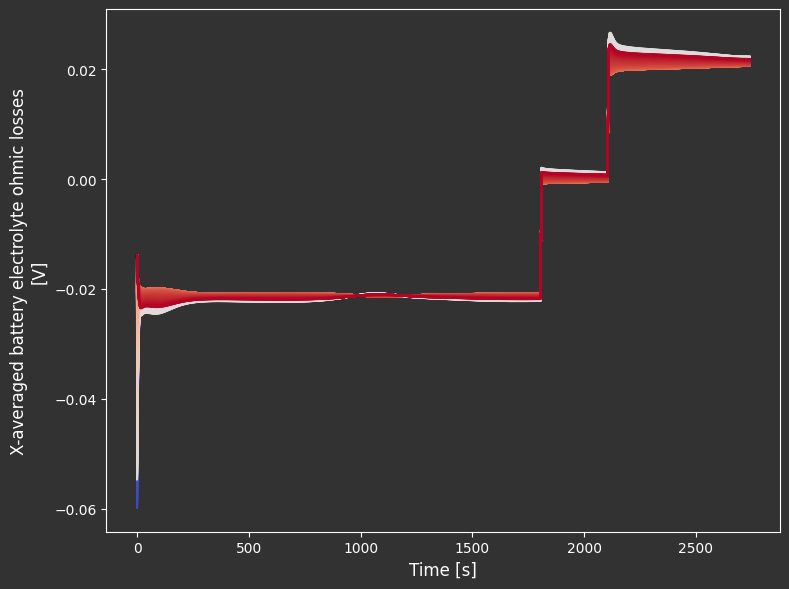

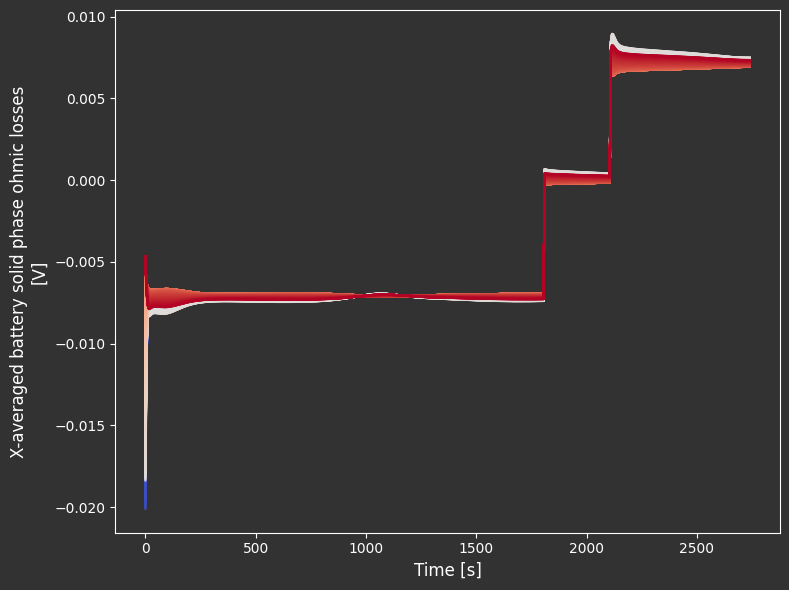

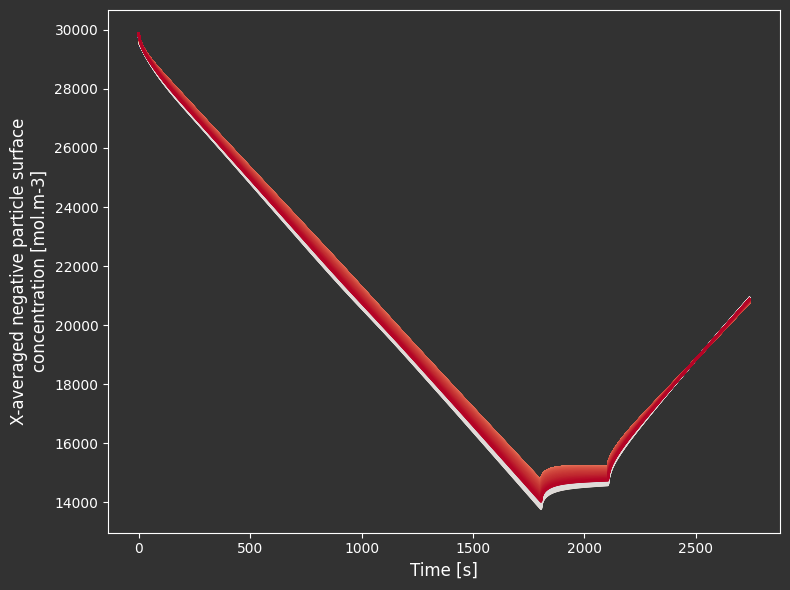

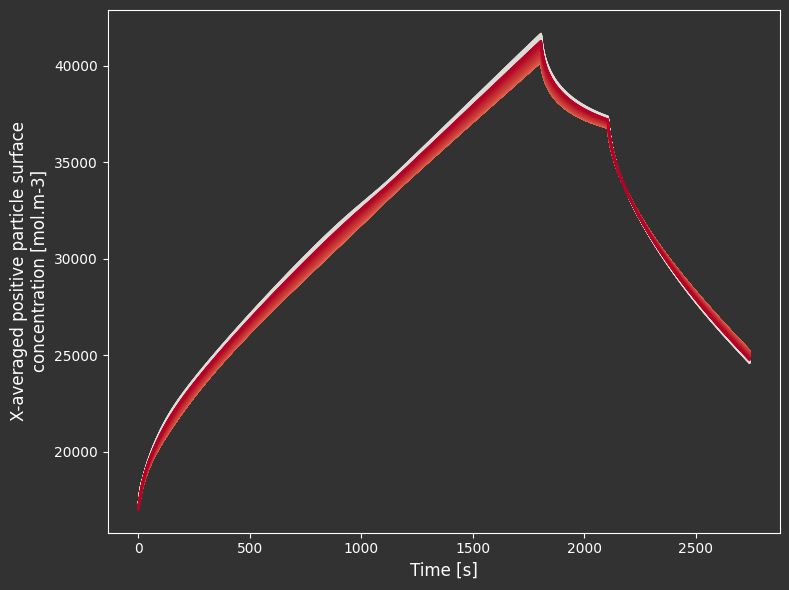

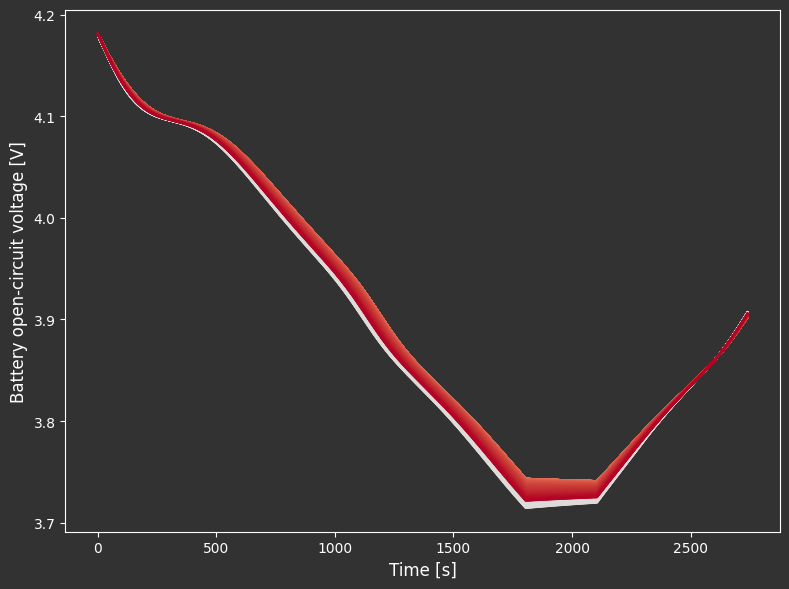

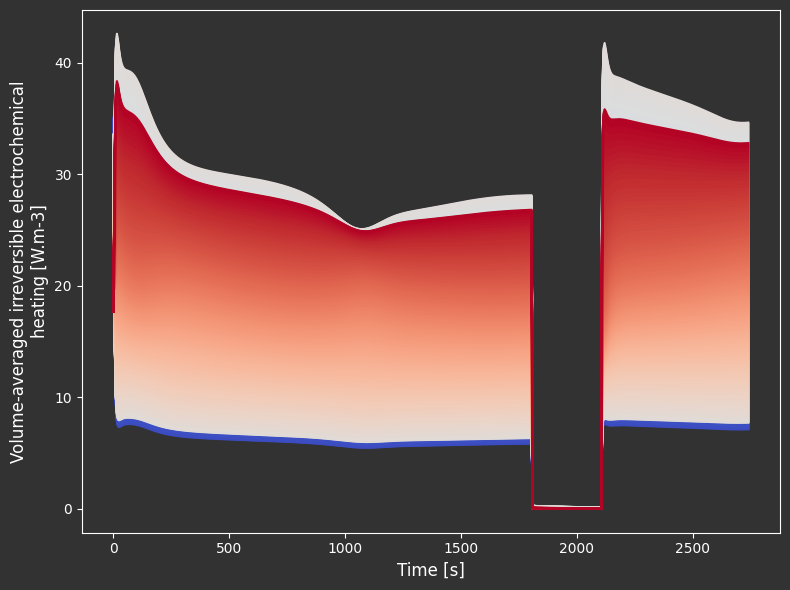

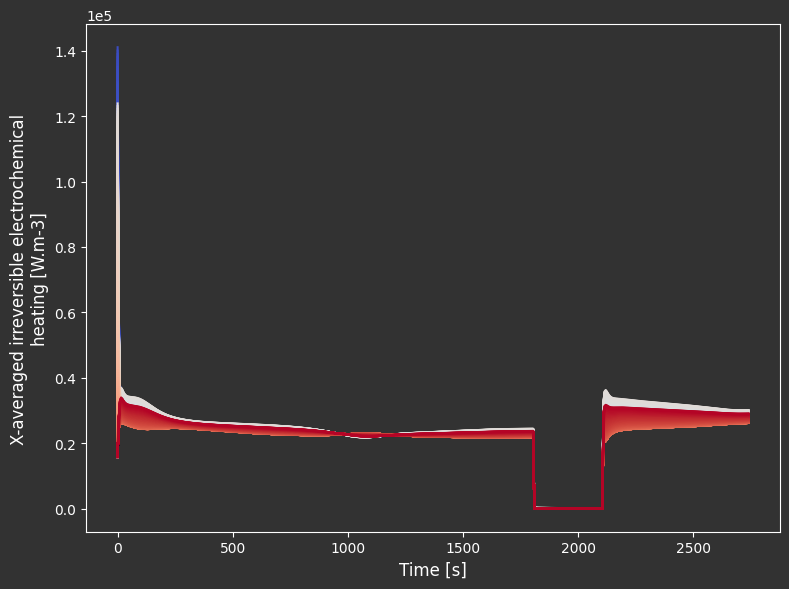

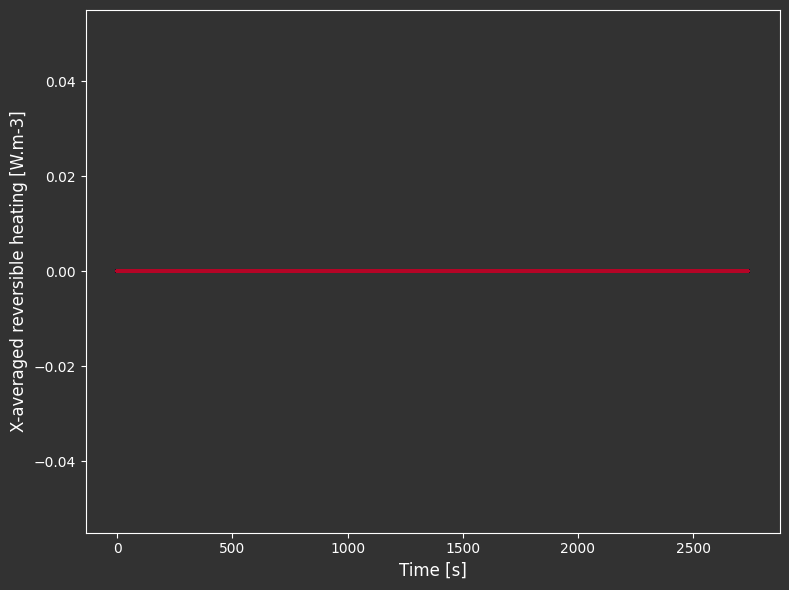

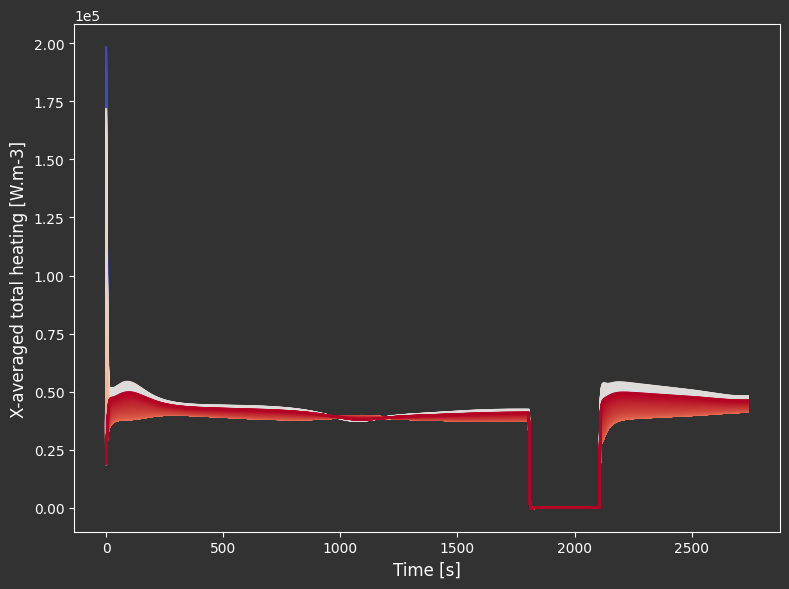

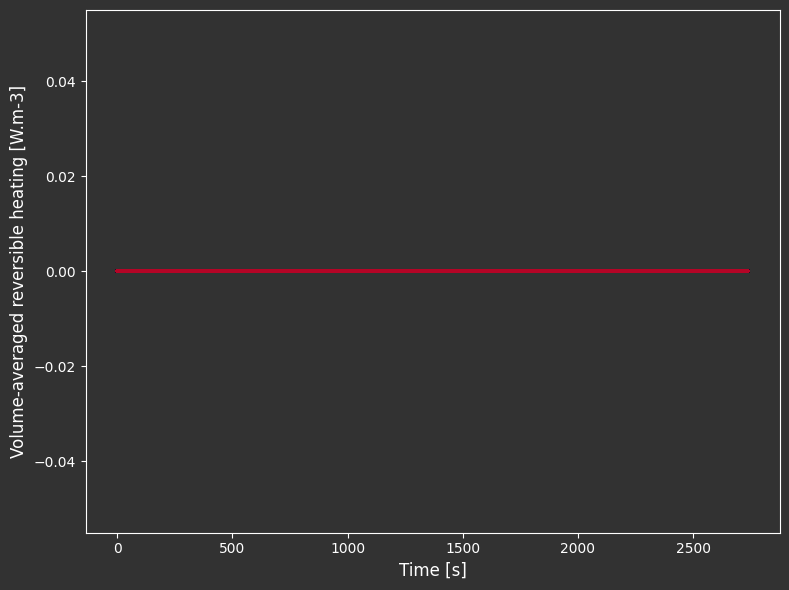

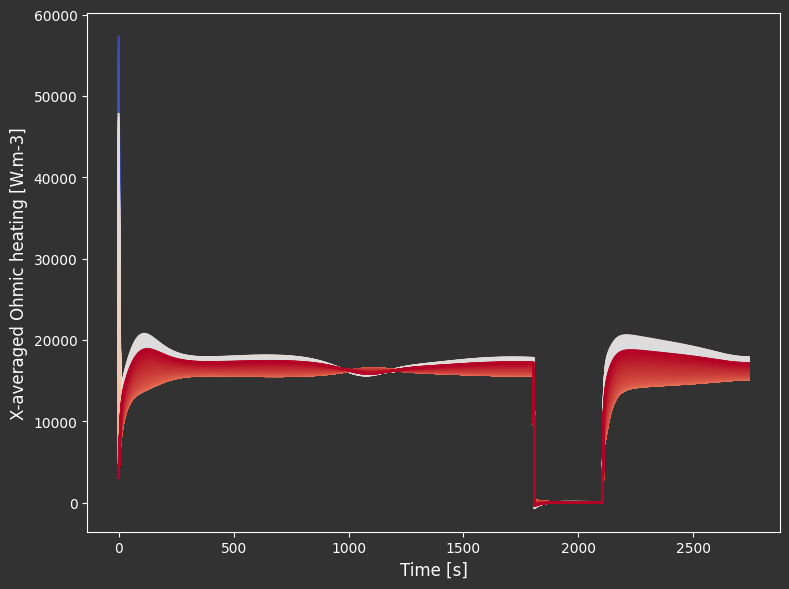

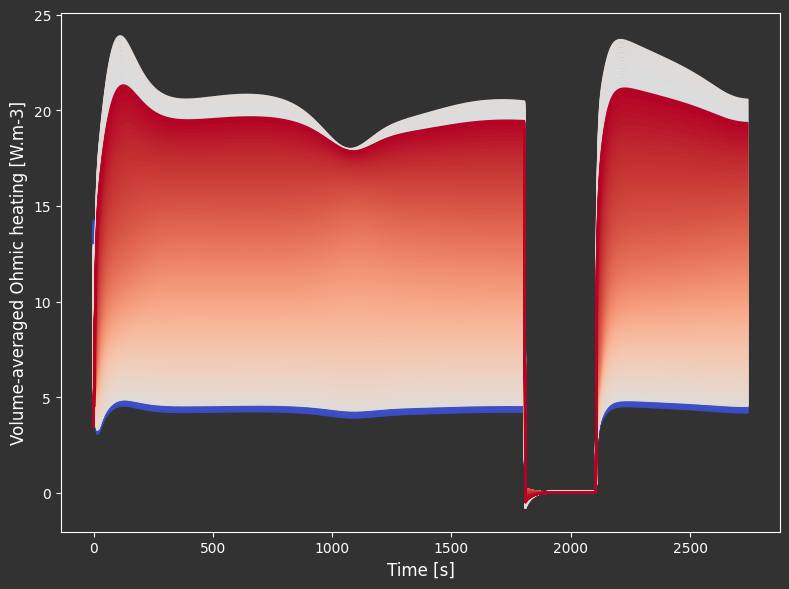

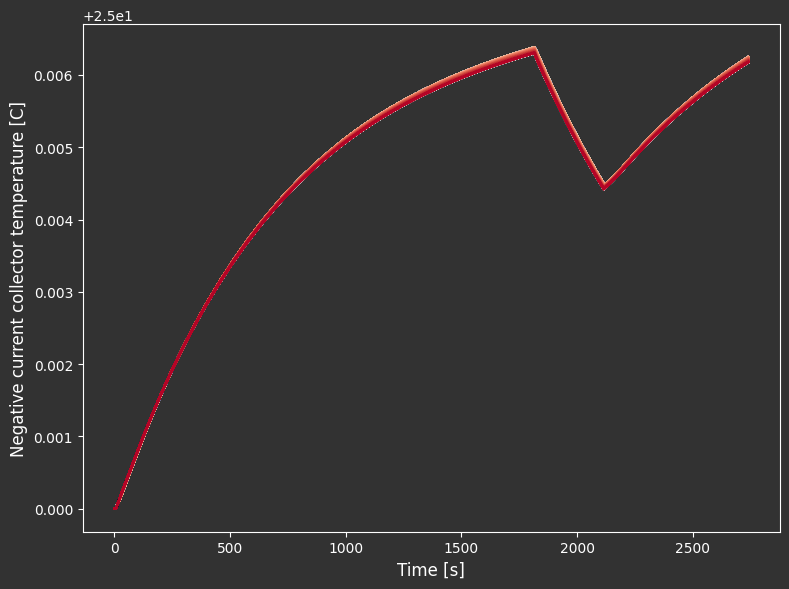

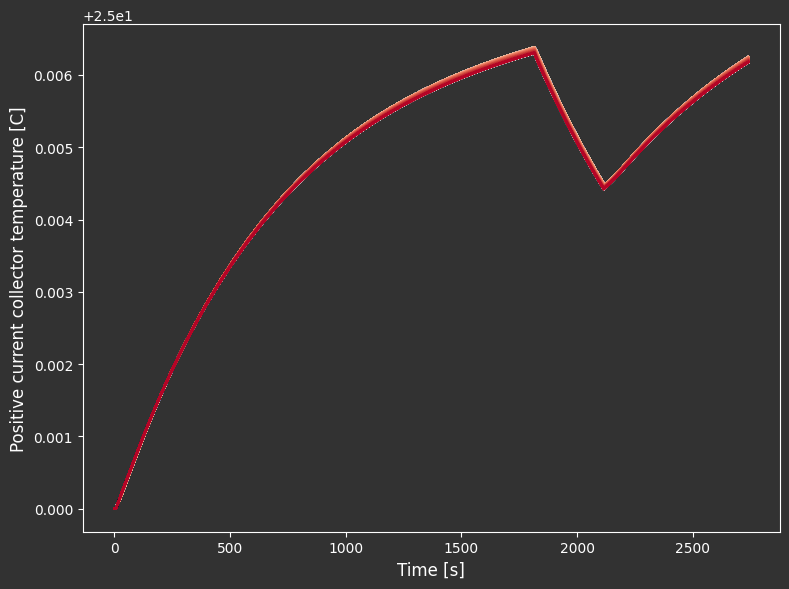

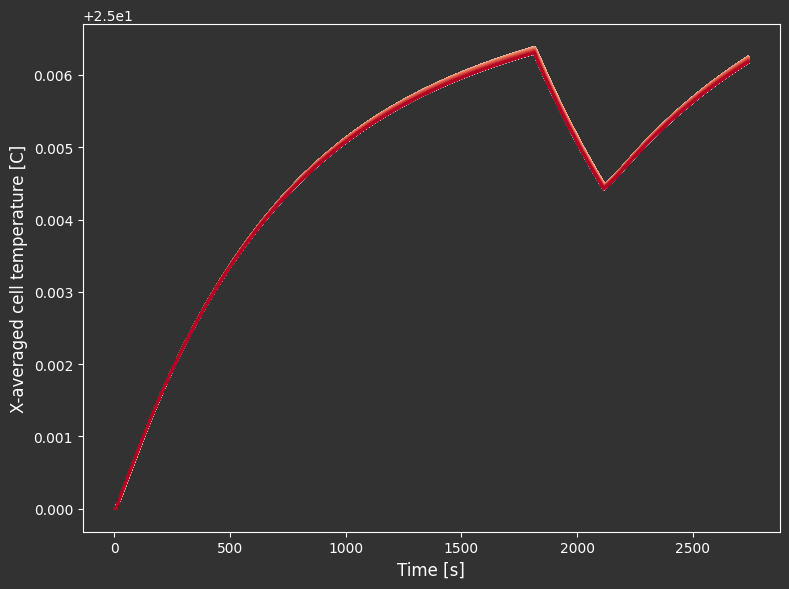

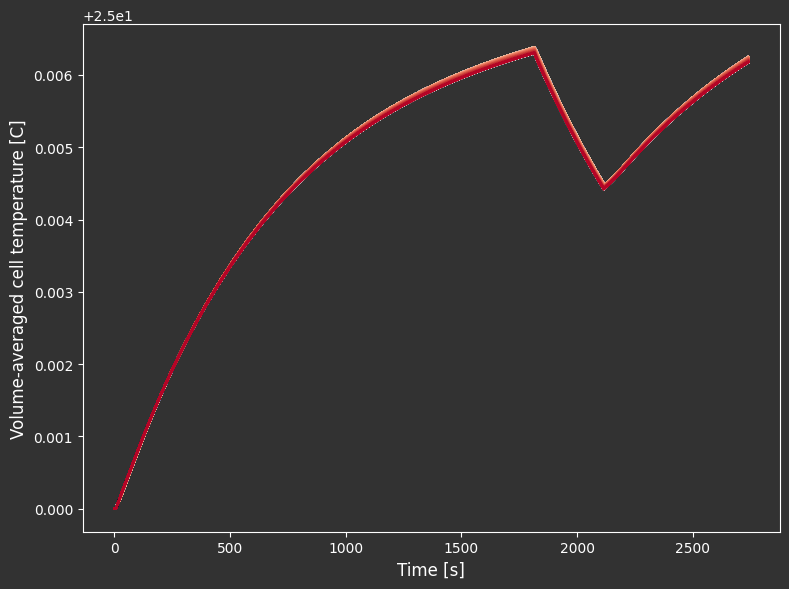

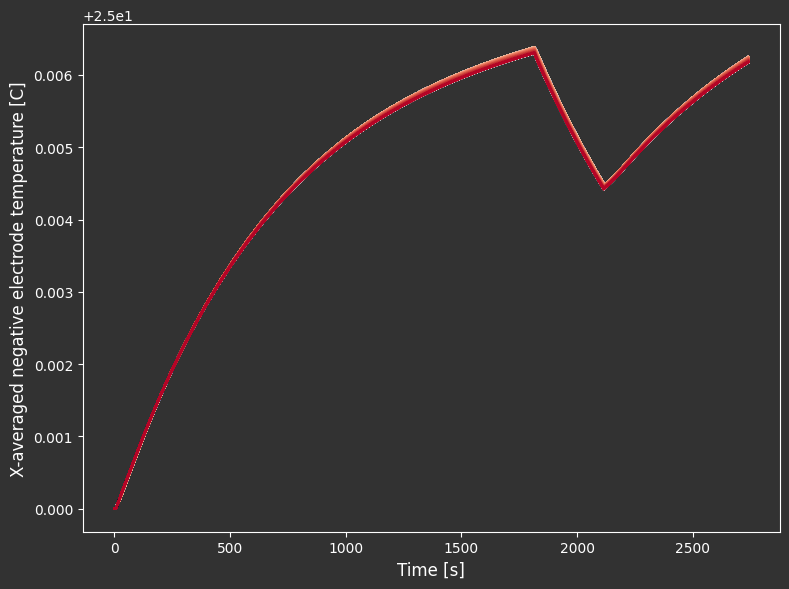

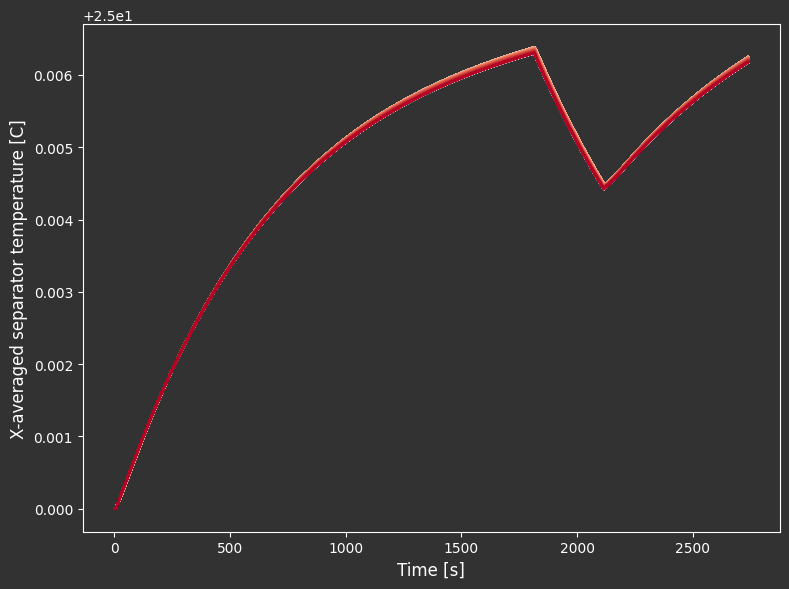

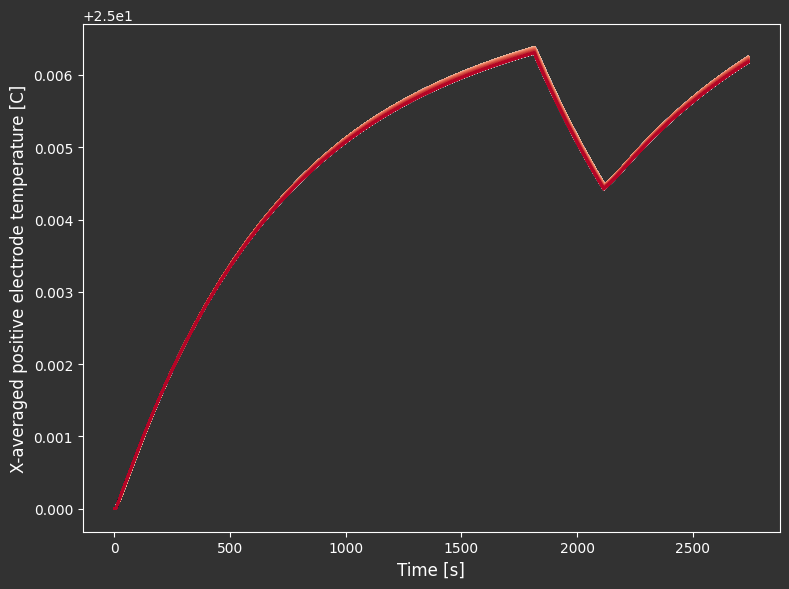

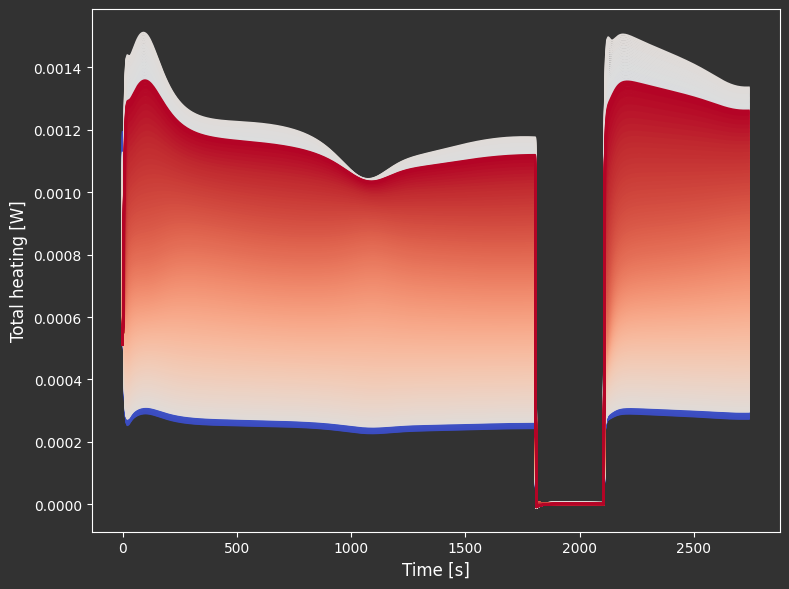

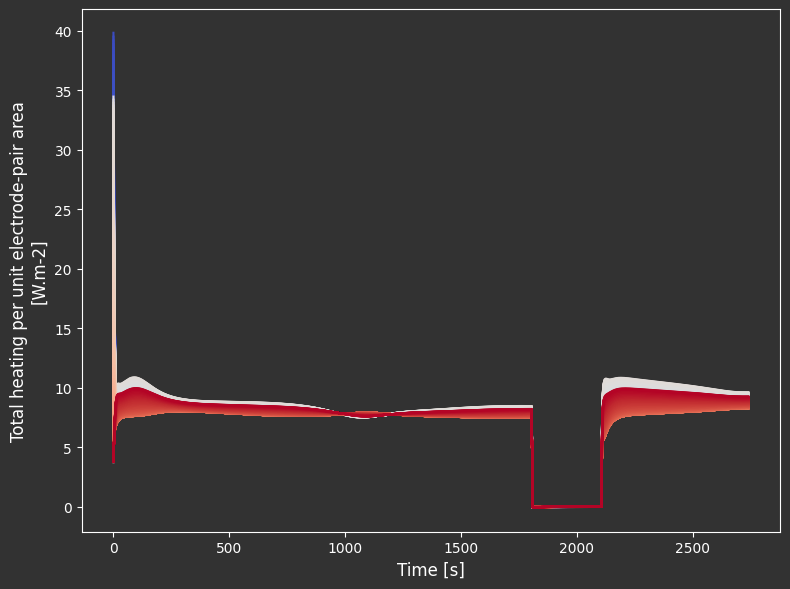

In [6]:
lp.plot_output(output)

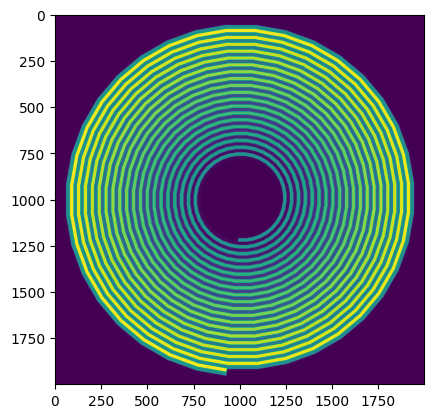

In [8]:
im_spm_map = jellybamm.interpolate_spm_number(project).astype(int)

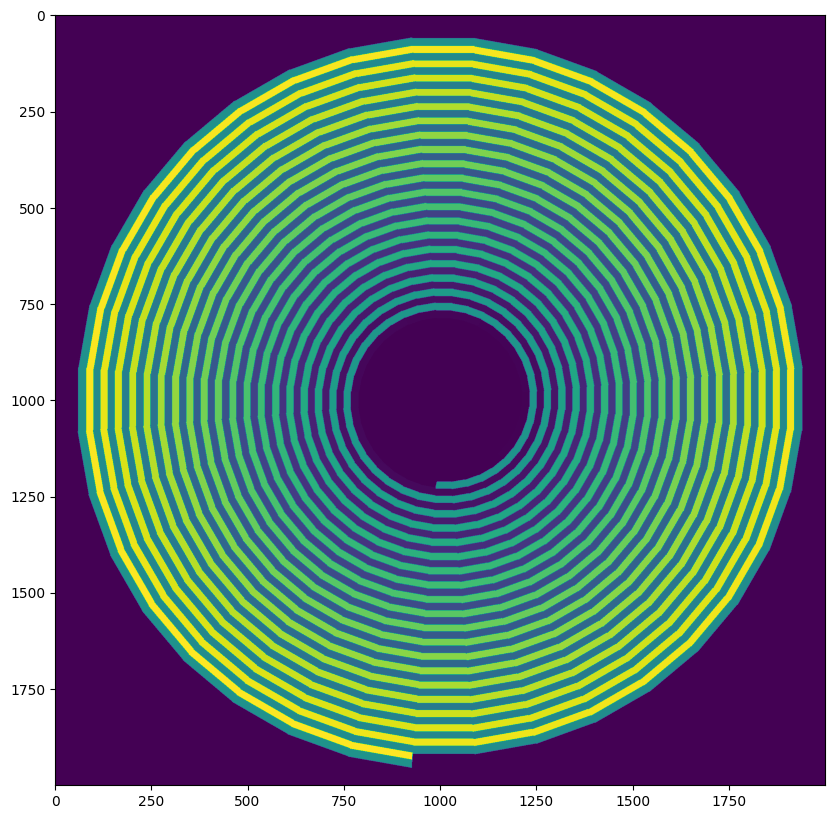

In [9]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(im_spm_map)

In [10]:
np.unique(im_spm_map)

array([  -1,    0,    1, ..., 1401, 1402, 1403])

In [11]:
mask = im_spm_map == -1

In [12]:
output.keys()

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Pack power [W]', 'Cell current [A]', 'Node voltage [V]', 'Cell internal resistance [Ohm]', 'Terminal voltage [V]', 'Surface open-circuit voltage [V]', 'Volume-averaged cell temperature [K]', 'Current collector current density [A.m-2]', 'X-averaged negative electrode extent of lithiation', 'X-averaged positive electrode extent of lithiation', 'Volume-averaged total heating [W.m-3]', 'X-averaged battery reaction overpotential [V]', 'X-averaged battery concentration overpotential [V]', 'X-averaged battery electrolyte ohmic losses [V]', 'X-averaged battery solid phase ohmic losses [V]', 'Battery open-circuit voltage [V]'])

In [13]:
t_data = output["Volume-averaged cell temperature [K]"][-1, :]
i_data = output["Current collector current density [A.m-2]"][-1, :]

In [14]:
arr = np.ones_like(im_spm_map).astype(float)

In [15]:
arr[~mask] = t_data[im_spm_map][~mask]
arr[mask] = np.nan

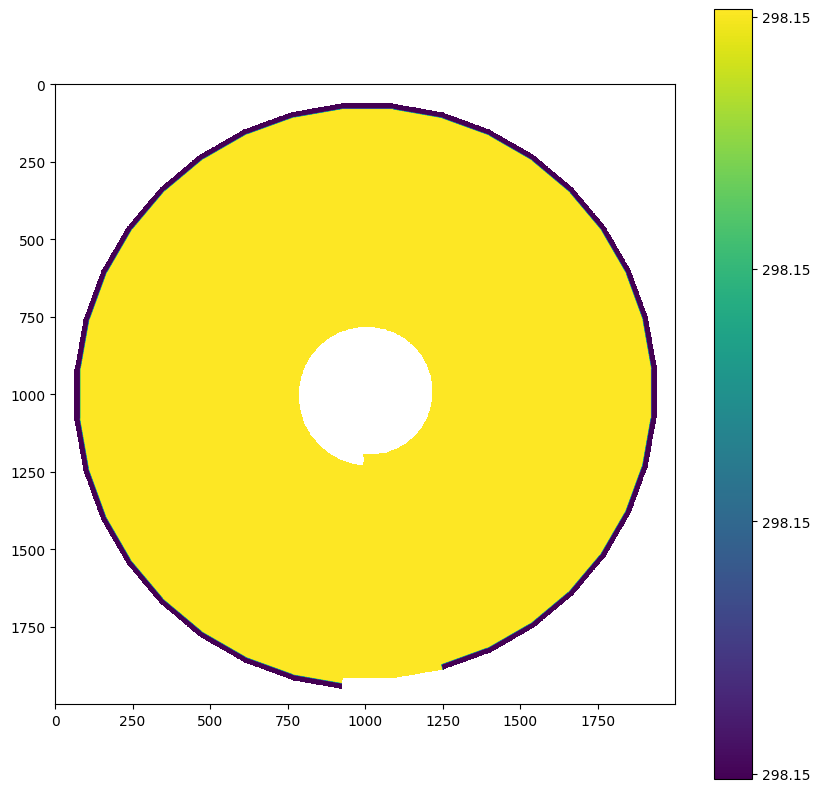

In [16]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
im = ax1.imshow(arr)
cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
cbar.ax.locator_params(nbins=6)

In [17]:
t_data.max() - t_data.min()

3.0517578e-05